# Model Experimentation
This notebook contains a minimal template for running ML experiments. 

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import sys
sys.path.insert(0, '../utils')
import model_utils
import geoutils

import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

SEED = 42

%load_ext autoreload
%autoreload 2

## File Locations

In [2]:
data_dir = "../data/"
input_file = data_dir + '20200509_dataset.csv'
output_dir = "../outputs/"

images_dir = data_dir + 'images/'
indices_dir = data_dir + 'indices/'
pos_mask_dir = data_dir + 'pos_masks/'
neg_mask_dir = data_dir + 'neg_masks/'

## Load Dataset

In [3]:
data = pd.read_csv(input_file).reset_index(drop=True).fillna(0)
class_dist = data['target'].value_counts().rename(index=model_utils.VALUE_CODES)

print('Data dimensions: {}'.format(data.shape))
print('\nClass distribution:\n{}\n'.format(class_dist))

data.head()

Data dimensions: (1029869, 69)

Class distribution:
Unoccupied land        798294
Formal settlement      207819
Informal settlement     23756
Name: target, dtype: int64



,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020,target,uid,area
0,0.15100,0.13225,0.14240,0.16430,0.18990,0.25700,0.2960,0.25510,0.32295,0.0396,...,-0.438625,0.151655,0.209614,0.479385,-0.665204,-0.060444,0.948025,3,39,0
1,0.15100,0.12885,0.13790,0.16185,0.18990,0.25700,0.2960,0.25755,0.32295,0.0396,...,-0.435450,0.151655,0.213526,0.488330,-0.663010,-0.059064,0.952352,3,39,0
2,0.15895,0.13730,0.15185,0.18915,0.22640,0.28555,0.3268,0.28085,0.35740,0.0416,...,-0.447333,0.145385,0.222971,0.473118,-0.661291,-0.060496,0.911748,3,39,0
3,0.15895,0.14630,0.17710,0.24240,0.22640,0.28555,0.3268,0.30980,0.35740,0.0416,...,-0.406751,0.145385,0.261163,0.554157,-0.632430,-0.047513,0.943184,3,39,0
4,0.15895,0.15345,0.19200,0.25950,0.25225,0.30040,0.3423,0.33510,0.36110,0.0416,...,-0.406525,0.131505,0.289682,0.570201,-0.623920,-0.042356,0.918867,3,39,0


## Resample Dataset

In [4]:
data = model_utils.resample(data, num_neg_samples=30000, random_state=SEED)

class_dist = data['target'].value_counts().rename(index=model_utils.VALUE_CODES)
area_dist = data['area'].value_counts().rename(index=model_utils.AREA_CODES)

print('Data dimensions: {}'.format(data.shape))
print('\nArea distribution:\n{}'.format(area_dist))
print('\nClass distribution:\n{}'.format(class_dist))
print('\nClass distribution (normalized):\n{}\n'.format(class_dist/len(data)))

data.head(3)

Data dimensions: (293756, 69)

Area distribution:
Uribia       40345
Riohacha     33501
Bogota       32720
Cucuta       32485
Arauca       32298
Arauquita    30778
Tibu         30730
Maicao       30552
Soacha       30347
Name: area, dtype: int64

Class distribution:
Unoccupied land        170723
Formal settlement       99277
Informal settlement     23756
Name: target, dtype: int64

Class distribution (normalized):
Unoccupied land        0.581173
Formal settlement      0.337957
Informal settlement    0.080870
Name: target, dtype: float64



,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020,target,uid,area
0,0.1748,0.12640,0.12590,0.12075,0.1288,0.2291,0.28325,0.2551,0.31165,0.03960,...,-0.325365,0.336843,0.097095,0.493299,-0.683798,-0.120547,1.149291,2,62,0
1,0.2093,0.19810,0.20230,0.21700,0.2178,0.2767,0.32240,0.3020,0.34780,0.03530,...,-0.212563,0.098564,0.242471,0.716410,-0.623340,-0.022285,1.042249,2,64,0
2,0.2062,0.20505,0.21575,0.23320,0.2083,0.2836,0.33810,0.3109,0.37400,0.03575,...,-0.235786,0.266124,0.158668,0.655587,-0.632521,-0.078219,1.101300,2,60,0


## ML Pipeline

In [5]:
from sklearn.linear_model import LogisticRegression

### Model Training & Evaluation

In [6]:
label = 'target'
features = [column  for column in data.columns[:-3]]
data[label] = data[label].replace({2:0, 3:0})

splits = data[['area']]
X = data[features]
y = data[label]

print('Class distribution:\n{}'.format(data['target'].value_counts()))

X.head(3)

Class distribution:
0    270000
1     23756
Name: target, dtype: int64


,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,ndvi_2019-2020,ndbi_2019-2020,savi_2019-2020,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020
0,0.1748,0.12640,0.12590,0.12075,0.1288,0.2291,0.28325,0.2551,0.31165,0.03960,...,0.361130,-0.102406,0.290864,-0.325365,0.336843,0.097095,0.493299,-0.683798,-0.120547,1.149291
1,0.2093,0.19810,0.20230,0.21700,0.2178,0.2767,0.32240,0.3020,0.34780,0.03530,...,0.033153,0.061558,0.076850,-0.212563,0.098564,0.242471,0.716410,-0.623340,-0.022285,1.042249
2,0.2062,0.20505,0.21575,0.23320,0.2083,0.2836,0.33810,0.3109,0.37400,0.03575,...,0.154722,-0.047662,0.183498,-0.235786,0.266124,0.158668,0.655587,-0.632521,-0.078219,1.101300


## Spatial Cross Validation

In [7]:
clf =  LogisticRegression()
out_of_fold_test, out_of_fold_preds = model_utils.spatial_cv(clf, X, y, splits=splits, verbose=2)

100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


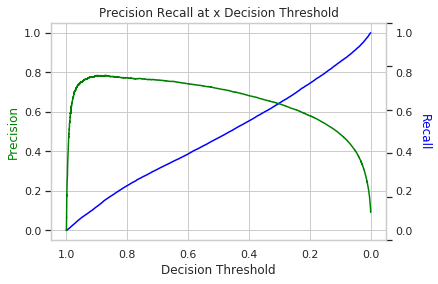

In [8]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(out_of_fold_test, out_of_fold_preds)

fig, ax = plt.subplots()
ax2 = ax.twinx()

line1 = ax.plot(thresholds, recall[:-1], color='blue')
line2 = ax.plot(thresholds, precision[:-1], color='green')

ax.tick_params(labelright=True)
ax2.tick_params(labelright=False)
ax2.grid(False)

ax.set_ylabel('Precision', color='green')
h = ax2.set_ylabel('Recall', color='blue', labelpad=45)
h.set_rotation(-90)

ax.set_xlabel('Decision Threshold')
plt.title('Precision Recall at x Decision Threshold')
plt.gca().invert_xaxis()
plt.show()

## Train Model

In [ ]:
clf = LogisticRegression()
X = data[features].fillna(0)
y = data[label]
clf.fit(X, y);

## Prediction

In [ ]:
areas = ['maicao', 'riohacha', 'uribia', 'arauca', 'cucuta', 'tibu', 'arauquita', 'soacha', 'bogota']
pd.set_option('use_inf_as_na', True)
area_dict = geoutils.get_filepaths(areas, images_dir, indices_dir, pos_mask_dir, neg_mask_dir)
data = geoutils.read_bands(area_dict, 'soacha')
print('Data dimensions: {}'.format(data.shape))
data.head(3)

In [ ]:
preds = clf.predict_proba(data[features].fillna(0))[:, 1]
preds[(data.iloc[:, :-1].sum(axis=1) == 0)] = -1

geoutils.save_predictions(
    preds, 
    image_src=area_dict['soacha']['images'][0], 
    output_file=output_dir+'20200507_soacha.tiff'
)